In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import text
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from database.connection import get_db_manager

In [ ]:
# CONFIGURACIÓN
TABLE_TYPE = 'domestic'
LEAGUES = [
    'ENG-Premier League',
    'ESP-La Liga', 
    'ITA-Serie A',
    'GER-Bundesliga',
    'FRA-Ligue 1'
]
SEASON = '2425'
MIN_MINUTES = 600

# JUGADORES TARGET
PLAYERS = [
    {'name': 'Joan García', 'search': 'Joan García', 'pos': 'GK', 'team': 'Espanyol', 'colors': ['#004D98', '#FFFFFF']},
    {'name': 'Dean Huijsen', 'search': 'Dean Huijsen', 'pos': 'DF', 'team': 'Bournemouth', 'colors': ['#DA020E', '#000000']},
    {'name': 'Álex Baena', 'search': 'Baena', 'pos': 'MF', 'team': 'Villarreal', 'colors': ['#FFFF00', '#003366']},
    {'name': 'Georges Mikautadze', 'search': 'Mikautadze', 'pos': 'FW', 'team': 'Lyon', 'colors': ['#0E4C92', '#FFFFFF']}
]

SAVE_PATH_BASE = "../images/mfichajes/"
os.makedirs(SAVE_PATH_BASE, exist_ok=True)

In [3]:
# Conexión BD
db = get_db_manager()

league_list_str = "', '".join(LEAGUES)
query = f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_{TABLE_TYPE} p
WHERE p.league IN ('{league_list_str}')
AND p.season = '{SEASON}'
ORDER BY p.league, p.season DESC, p.team, p.player_name
"""

df_raw = pd.read_sql(query, db.engine)
db.close()

print(f"Extraídos: {df_raw.shape[0]} registros, {df_raw.shape[1]} columnas")
df_raw.head()

2025-08-31 17:26:19,044 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2025-08-31 17:26:20,146 - database.connection - INFO - Database connection successful


Extraídos: 2772 registros, 10 columnas


,unique_player_id,player_name,team,league,season,position,nationality,age,fbref_metrics,understat_metrics
0,4297cac0772af3c8,Ben White,Arsenal,ENG-Premier League,2425,DF,ENG,26.0,"{'CS': '1', 'FK': '0', 'OG': '0', '/90': '-0.0...","{'understat_xa': '1.4500398263335228', 'unders..."
1,258ed61985702bb2,Bukayo Saka,Arsenal,ENG-Premier League,2425,"FW,MF",ENG,22.0,"{'FK': '1', 'OG': '0', 'Crs': '117', 'Fld': '3...","{'understat_xa': '11.583731275051832', 'unders..."
2,57f809b3be3768e0,David Raya,Arsenal,ENG-Premier League,2425,GK,ESP,28.0,"{'CS': '13', 'FK': '0', 'OG': '0', '/90': '0.0...","{'understat_xa': '0.09363602846860886', 'under..."
3,bb58d04ee12cd7fd,Declan Rice,Arsenal,ENG-Premier League,2425,MF,ENG,25.0,"{'FK': '2', 'OG': '0', 'Crs': '164', 'Fld': '1...","{'understat_xa': '9.060594327747822', 'underst..."
4,40384e981d1a5c3c,Ethan Nwaneri,Arsenal,ENG-Premier League,2425,"FW,MF",ENG,17.0,"{'FK': '1', 'OG': '0', 'Crs': '54', 'Fld': '5'...","{'understat_xa': '1.1617773352190852', 'unders..."


In [4]:
# Verificar posiciones disponibles
positions = df_raw['position'].value_counts().sort_index()
print(f"Posiciones: {sorted(df_raw['position'].unique())}")

# Filtrar por minutos mínimos
df_filtered = df_raw[
    df_raw['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) >= MIN_MINUTES
].copy()

print(f"Filtro {MIN_MINUTES}+ min: {df_filtered.shape[0]} jugadores")
df_filtered.head()

Posiciones: ['DF', 'DF,FW', 'DF,MF', 'FW', 'FW,DF', 'FW,MF', 'GK', 'MF', 'MF,DF', 'MF,FW']
Filtro 600+ min: 1811 jugadores


,unique_player_id,player_name,team,league,season,position,nationality,age,fbref_metrics,understat_metrics
0,4297cac0772af3c8,Ben White,Arsenal,ENG-Premier League,2425,DF,ENG,26.0,"{'CS': '1', 'FK': '0', 'OG': '0', '/90': '-0.0...","{'understat_xa': '1.4500398263335228', 'unders..."
1,258ed61985702bb2,Bukayo Saka,Arsenal,ENG-Premier League,2425,"FW,MF",ENG,22.0,"{'FK': '1', 'OG': '0', 'Crs': '117', 'Fld': '3...","{'understat_xa': '11.583731275051832', 'unders..."
2,57f809b3be3768e0,David Raya,Arsenal,ENG-Premier League,2425,GK,ESP,28.0,"{'CS': '13', 'FK': '0', 'OG': '0', '/90': '0.0...","{'understat_xa': '0.09363602846860886', 'under..."
3,bb58d04ee12cd7fd,Declan Rice,Arsenal,ENG-Premier League,2425,MF,ENG,25.0,"{'FK': '2', 'OG': '0', 'Crs': '164', 'Fld': '1...","{'understat_xa': '9.060594327747822', 'underst..."
4,40384e981d1a5c3c,Ethan Nwaneri,Arsenal,ENG-Premier League,2425,"FW,MF",ENG,17.0,"{'FK': '1', 'OG': '0', 'Crs': '54', 'Fld': '5'...","{'understat_xa': '1.1617773352190852', 'unders..."


In [5]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    
    if value is None or pd.isna(value):
        return np.nan
    
    if isinstance(value, str):
        if value.strip() == '':
            return np.nan
        
        if value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    
    return np.nan

In [6]:
# Extraer métricas numéricas
fbref_nums = extract_metrics(df_filtered, 'fbref_metrics')
understat_nums = extract_metrics(df_filtered, 'understat_metrics')
print(f"FBref: {fbref_nums.shape[1]} métricas | Understat: {understat_nums.shape[1]} métricas")

FBref: 185 métricas | Understat: 10 métricas


In [7]:
# Métricas a excluir de per90
exclude_per90 = {
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'minutes_played', 'wins', 'draws', 'losses',
    'understat_buildup_involvement_pct', 'understat_player_id', 'understat_team_id'
}

# Calcular per90 FBref
fbref_per90 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_per90)]
fbref_per90 = (fbref_per90.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
fbref_per90.columns = [f'{col}_per90' for col in fbref_per90.columns]

# Calcular per90 Understat
understat_per90 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_per90)]
understat_per90 = (understat_per90.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
understat_per90.columns = [f'{col}_per90' for col in understat_per90.columns]

print(f"Per90: {fbref_per90.shape[1]} + {understat_per90.shape[1]}")

# COMBINAR todas las métricas
all_metrics = pd.concat([fbref_nums, understat_nums, fbref_per90, understat_per90], axis=1)

Per90: 154 + 7


In [8]:
# Calcular percentiles
all_percentiles = all_metrics.rank(pct=True) * 98 + 1
all_percentiles = all_percentiles.round(0).astype('Int64')
all_percentiles.columns = [f'{col}_pct' for col in all_percentiles.columns]

print(f"Métricas totales: {all_metrics.shape[1]}")
print(f"Percentiles totales: {all_percentiles.shape[1]}")

Métricas totales: 356
Percentiles totales: 356


In [9]:
# DataFrame final consolidado
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']

df_final = pd.concat([
    df_filtered[base_cols],
    all_metrics,
    all_percentiles
], axis=1)

print(f"DataFrame final: {df_final.shape[0]} filas, {df_final.shape[1]} columnas")

# Limpieza de Series anidados
def clean_series_values(df):
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        
        if series_mask.any():
            print(f"Limpiando Series en: {col}")
            df[col] = df[col].apply(
                lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x
            )
    return df

df_final = clean_series_values(df_final)

# Eliminar columnas problemáticas
problem_cols = ['shots_on_target_pct']
df_final = df_final.drop(columns=[col for col in problem_cols if col in df_final.columns])

print(f"Limpieza completada: {df_final.shape[1]} columnas finales")

DataFrame final: 1811 filas, 718 columnas
Limpiando Series en: shots_on_target_pct
Limpiando Series en: shots_on_target_pct
Limpieza completada: 716 columnas finales


In [10]:
# EXPLORACIÓN MÉTRICAS DISPONIBLES
print("MÉTRICAS FBREF DISPONIBLES:")
print("=" * 50)
fbref_sorted = sorted(list(fbref_nums.columns))
for i, metric in enumerate(fbref_sorted, 1):
    print(f"{i:2d}. {metric}")

print(f"\nTotal FBref: {len(fbref_sorted)}")

print("\nMÉTRICAS UNDERSTAT DISPONIBLES:")
print("=" * 50)
understat_sorted = sorted(list(understat_nums.columns))
for i, metric in enumerate(understat_sorted, 1):
    print(f"{i:2d}. {metric}")

print(f"\nTotal Understat: {len(understat_sorted)}")

print("\nMÉTRICAS PER90 DISPONIBLES:")
print("=" * 50)
per90_sorted = sorted([col for col in all_metrics.columns if col.endswith('_per90')])
for i, metric in enumerate(per90_sorted[:20], 1):
    print(f"{i:2d}. {metric}")
if len(per90_sorted) > 20:
    print(f"... y {len(per90_sorted) - 20} más")

print(f"\nTotal Per90: {len(per90_sorted)}")

MÉTRICAS FBREF DISPONIBLES:
 1. /90
 2. 2CrdY
 3. A-xAG
 4. Aerial Duels_Lost
 5. Aerial Duels_Won
 6. Aerial Duels_Won%
 7. Blocks_Blocks
 8. Blocks_Pass
 9. Blocks_Sh
10. CS
11. CS%
12. Carries_1/3
13. Carries_CPA
14. Carries_Carries
15. Carries_Dis
16. Carries_Mis
17. Carries_PrgC
18. Carries_PrgDist
19. Carries_TotDist
20. Challenges_Att
21. Challenges_Lost
22. Challenges_Tkl
23. Challenges_Tkl%
24. Corner Kicks_In
25. Corner Kicks_Out
26. Corner Kicks_Str
27. Crosses_Opp
28. Crosses_Stp
29. Crosses_Stp%
30. Crs
31. CrsPA
32. FK
33. Fld
34. Fls
35. G+A-PK
36. G-xG
37. GA90
38. GCA Types_Def
39. GCA Types_Fld
40. GCA Types_PassDead
41. GCA Types_PassLive
42. GCA Types_Sh
43. GCA Types_TO
44. GCA_GCA
45. GCA_GCA90
46. Goal Kicks_Att
47. Goal Kicks_AvgLen
48. Goal Kicks_Launch%
49. Goals_CK
50. Goals_FK
51. Goals_GA
52. Goals_OG
53. Goals_PKA
54. Launched_Att
55. Launched_Cmp
56. Launched_Cmp%
57. Min%
58. OG
59. Off
60. Outcomes_Blocks
61. Outcomes_Cmp
62. Outcomes_Off
63. PKcon
64. 

In [11]:
# Buscar jugadores
player_ids = {}

for player in PLAYERS:
    search_results = df_filtered[
        df_filtered['player_name'].str.contains(player['search'], case=False, na=False)
    ]
    
    print(f"\n{player['name']} (búsqueda: '{player['search']}'):")
    if len(search_results) > 0:
        for _, p in search_results.iterrows():
            print(f"  {p['unique_player_id']} - {p['player_name']} ({p['team']}, {p['league']}, {p['position']})")
            
            if player['name'] not in player_ids:
                player_ids[player['name']] = p['unique_player_id']
    else:
        print(f"  No encontrado")

print(f"\nJugadores encontrados: {len(player_ids)}/{len(PLAYERS)}")


Joan García (búsqueda: 'Joan García'):
  2c4b99fb15b2169c - Joan García (Espanyol, ESP-La Liga, GK)

Dean Huijsen (búsqueda: 'Dean Huijsen'):
  e320695209f68913 - Dean Huijsen (Bournemouth, ENG-Premier League, DF)

Álex Baena (búsqueda: 'Baena'):
  eb4c447d1a00eb39 - Alex Baena (Villarreal, ESP-La Liga, MF,FW)

Georges Mikautadze (búsqueda: 'Mikautadze'):
  a8fe4e1b129cf192 - Georges Mikautadze (Lyon, FRA-Ligue 1, FW)

Jugadores encontrados: 4/4


In [12]:
# Configurar IDs manualmente (copiar de la búsqueda anterior)
PLAYER_1_ID = "2c4b99fb15b2169c"  # Joan García
PLAYER_2_ID = "e320695209f68913"  # Dean Huijsen
PLAYER_3_ID = "eb4c447d1a00eb39"  # Álex Baena
PLAYER_4_ID = "a8fe4e1b129cf192"  # Georges Mikautadze

In [13]:
# PORTERO (GK) - Joan García
gk_metrics = [
      'Saves', 'Save%', 'PSxG', 'PSxG+/-',
      'Goal Kicks_Launch%', 'passes_completed', 'pass_completion_pct', 'Passes_AvgLen',
      'Crosses_Stp%', 'errors'
  ]

gk_titles = [
      'Saves', 'Save %', 'PSxG', 'PSxG +/-',
      'Long Kicks %', 'Passes', 'Pass Accuracy %', 'Avg Pass Length',
      'Crosses Stopped %', 'Errors'
  ]

# DEFENSA (DF) - Dean Huijsen
df_metrics = [
      'Tackles_Tkl', 'interceptions', 'Blocks_Blocks', 'clearances',
      'Aerial Duels_Won%', 'passes_completed', 'progressive_passes', 'pass_completion_pct',
      'errors', 'Fls'
  ]

df_titles = [
      'Tackles', 'Interceptions', 'Blocks', 'Clearances',
      'Aerial Duels Won %', 'Passes', 'Progressive Passes', 'Pass Accuracy %',
      'Errors', 'Fouls'
  ]

# MEDIOCAMPO (MF) - Álex Baena
mf_metrics = [
      'goals', 'assists', 'expected_assists', 'key_passes',
      'passes_completed', 'progressive_passes', 'pass_completion_pct', 'Tackles_Tkl',
      'interceptions', 'Take-Ons_Succ'
  ]

mf_titles = [
      'Goals', 'Assists', 'Expected Assists', 'Key Passes',
      'Passes', 'Progressive Passes', 'Pass Accuracy %', 'Tackles',
      'Interceptions', 'Dribbles'
  ]

# DELANTERO (FW) - Georges Mikautadze
fw_metrics = [
      'goals', 'shots', 'expected_goals', 'assists',
      'key_passes', 'Take-Ons_Succ', 'Touches_Att Pen', 'Carries_Mis',
      'Fld', 'progressive_passes'
  ]

fw_titles = [
      'Goals', 'Shots', 'Expected Goals', 'Assists',
      'Key Passes', 'Dribbles', 'Touches Box', 'Dispossessed',
      'Fouls Drawn', 'Progressive Passes'
  ]

# Verificar longitud
configs = [
      ('GK', gk_metrics, gk_titles),
      ('DF', df_metrics, df_titles),
      ('MF', mf_metrics, mf_titles),
      ('FW', fw_metrics, fw_titles)
  ]

for pos, metrics, titles in configs:
      if len(metrics) == 10 and len(titles) == 10:
          print(f"{pos}: ✓ {len(metrics)} métricas configuradas")
      else:
          print(f"{pos}: ✗ {len(metrics)} métricas, {len(titles)} títulos")

GK: ✓ 10 métricas configuradas
DF: ✓ 10 métricas configuradas
MF: ✓ 10 métricas configuradas
FW: ✓ 10 métricas configuradas



Generando radar Joan García (GK)...
Dataset: 137 jugadores GK
✓ Radar generado: ../images/radares_2425/Joan_Garcia_GK.png


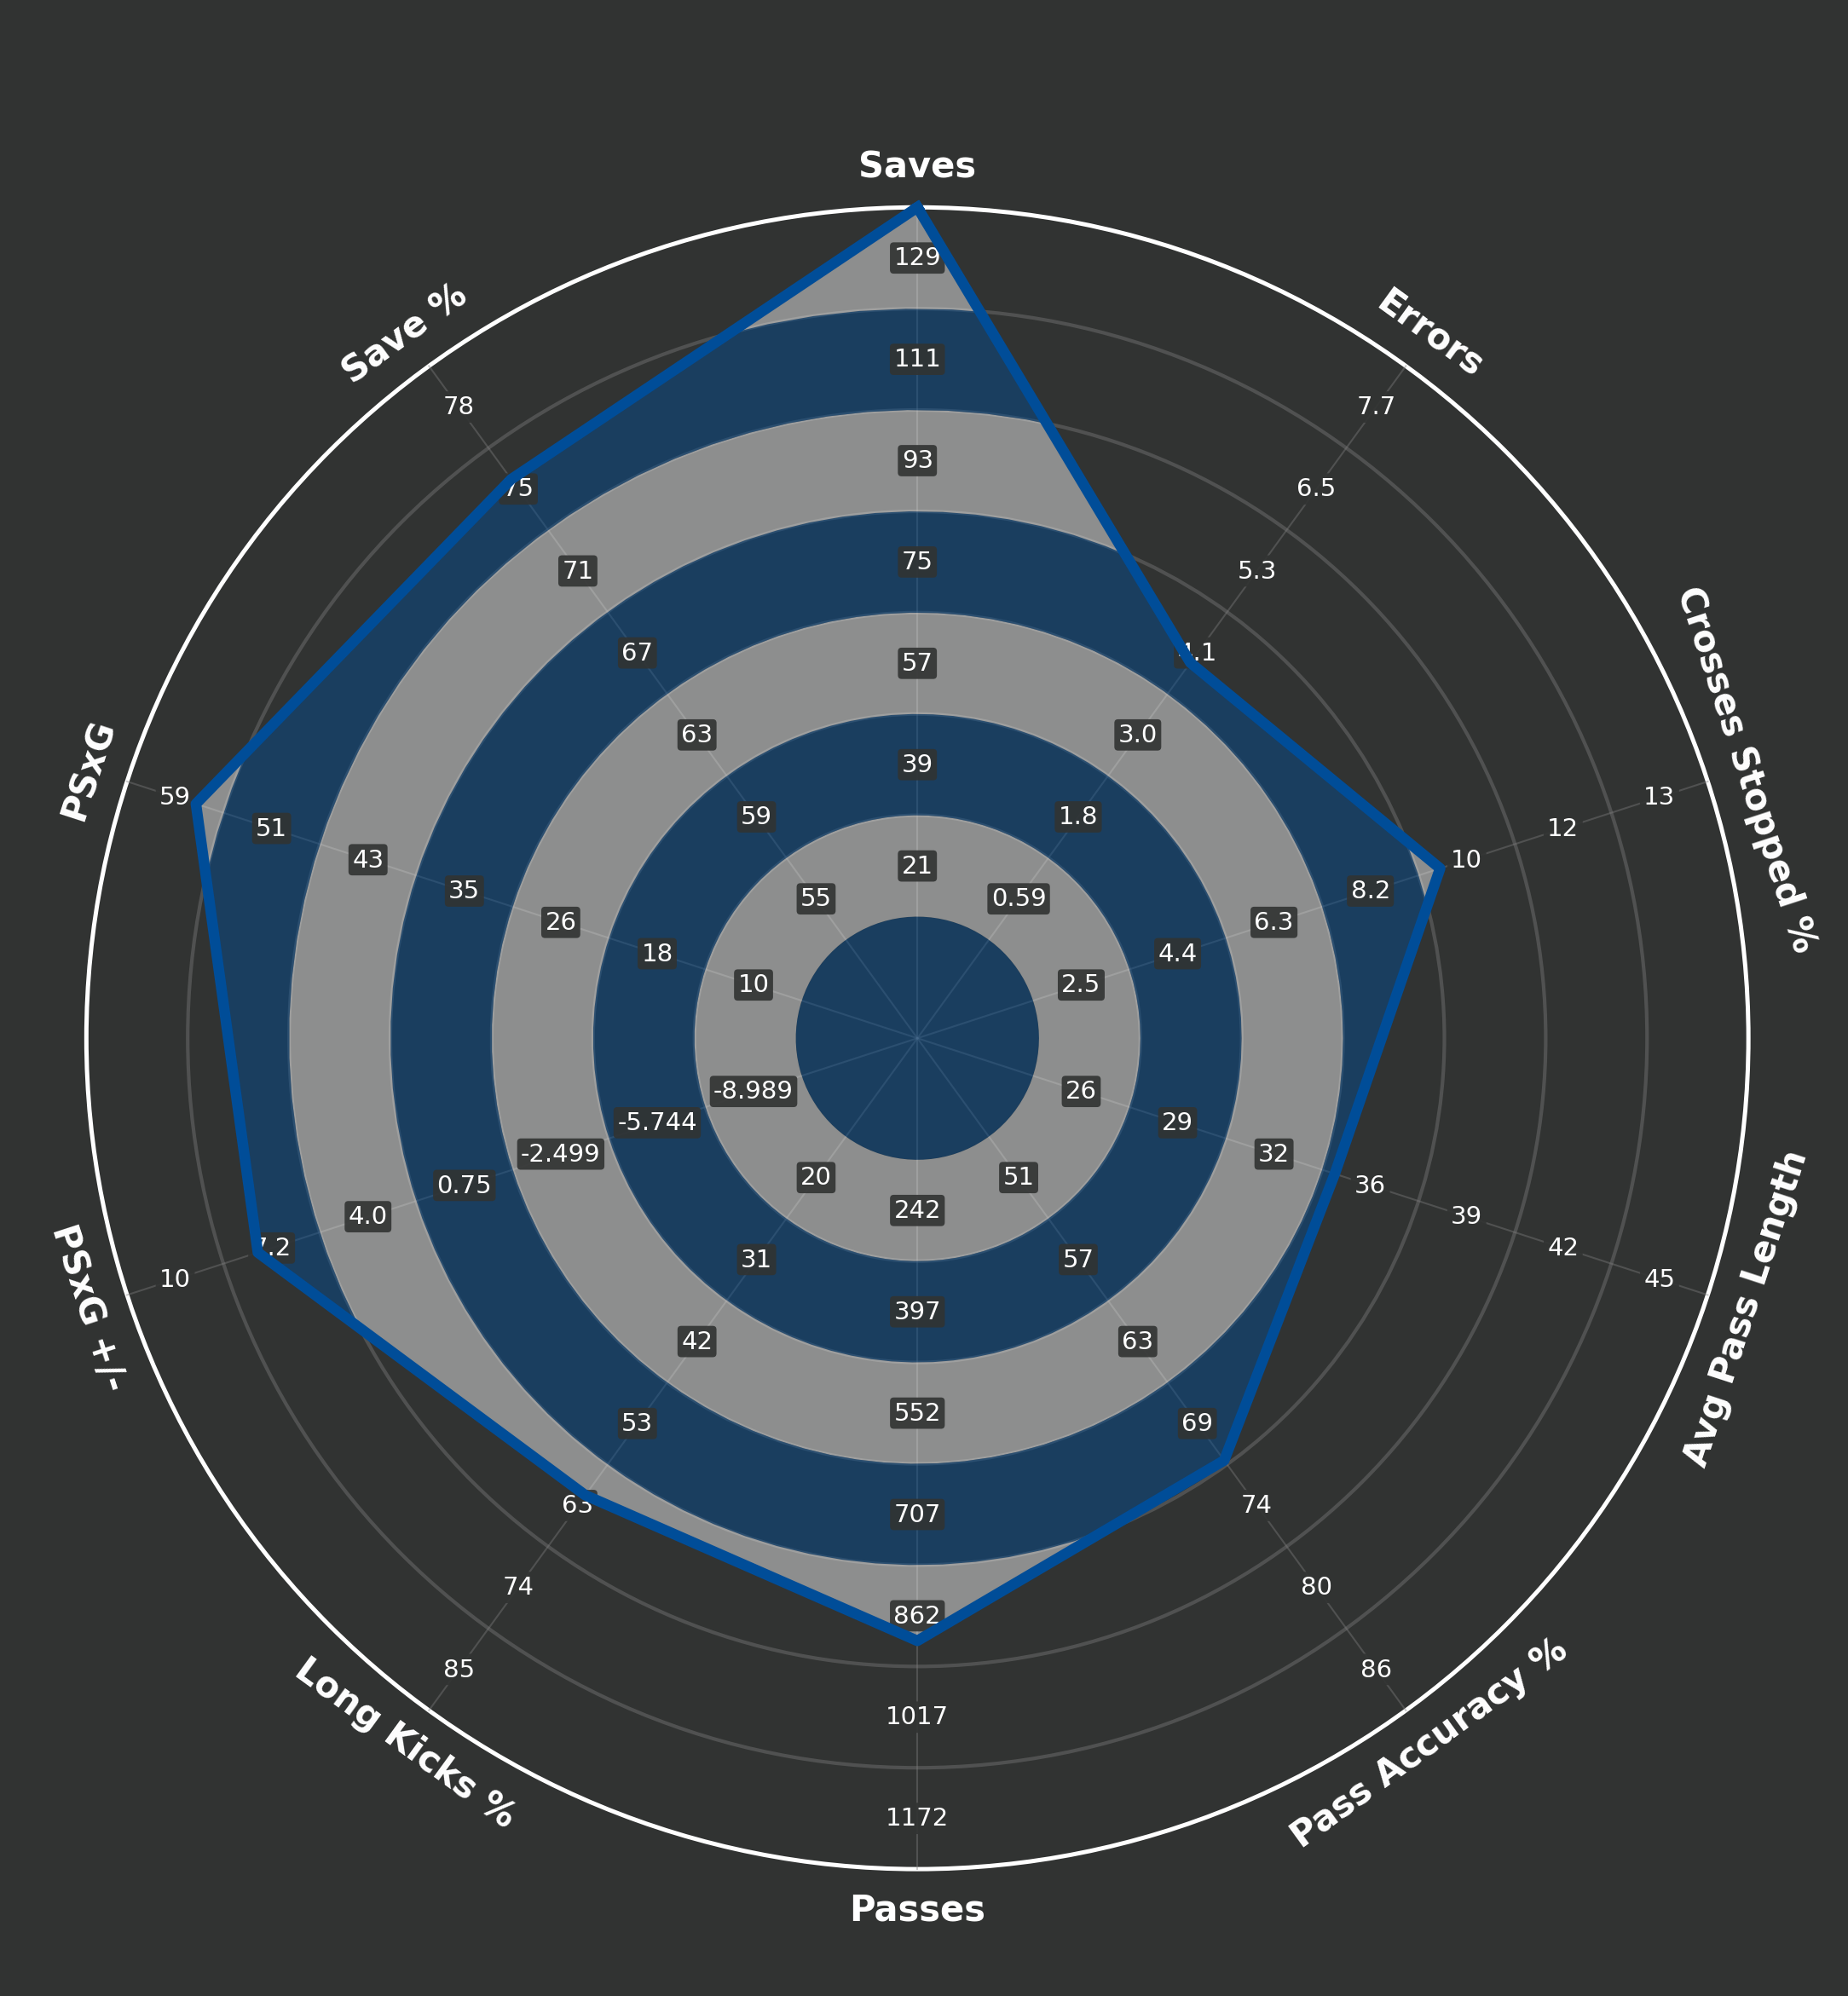


Generando radar Dean Huijsen (DF)...
Dataset: 700 jugadores DF
✓ Radar generado: ../images/radares_2425/Dean_Huijsen_DF.png


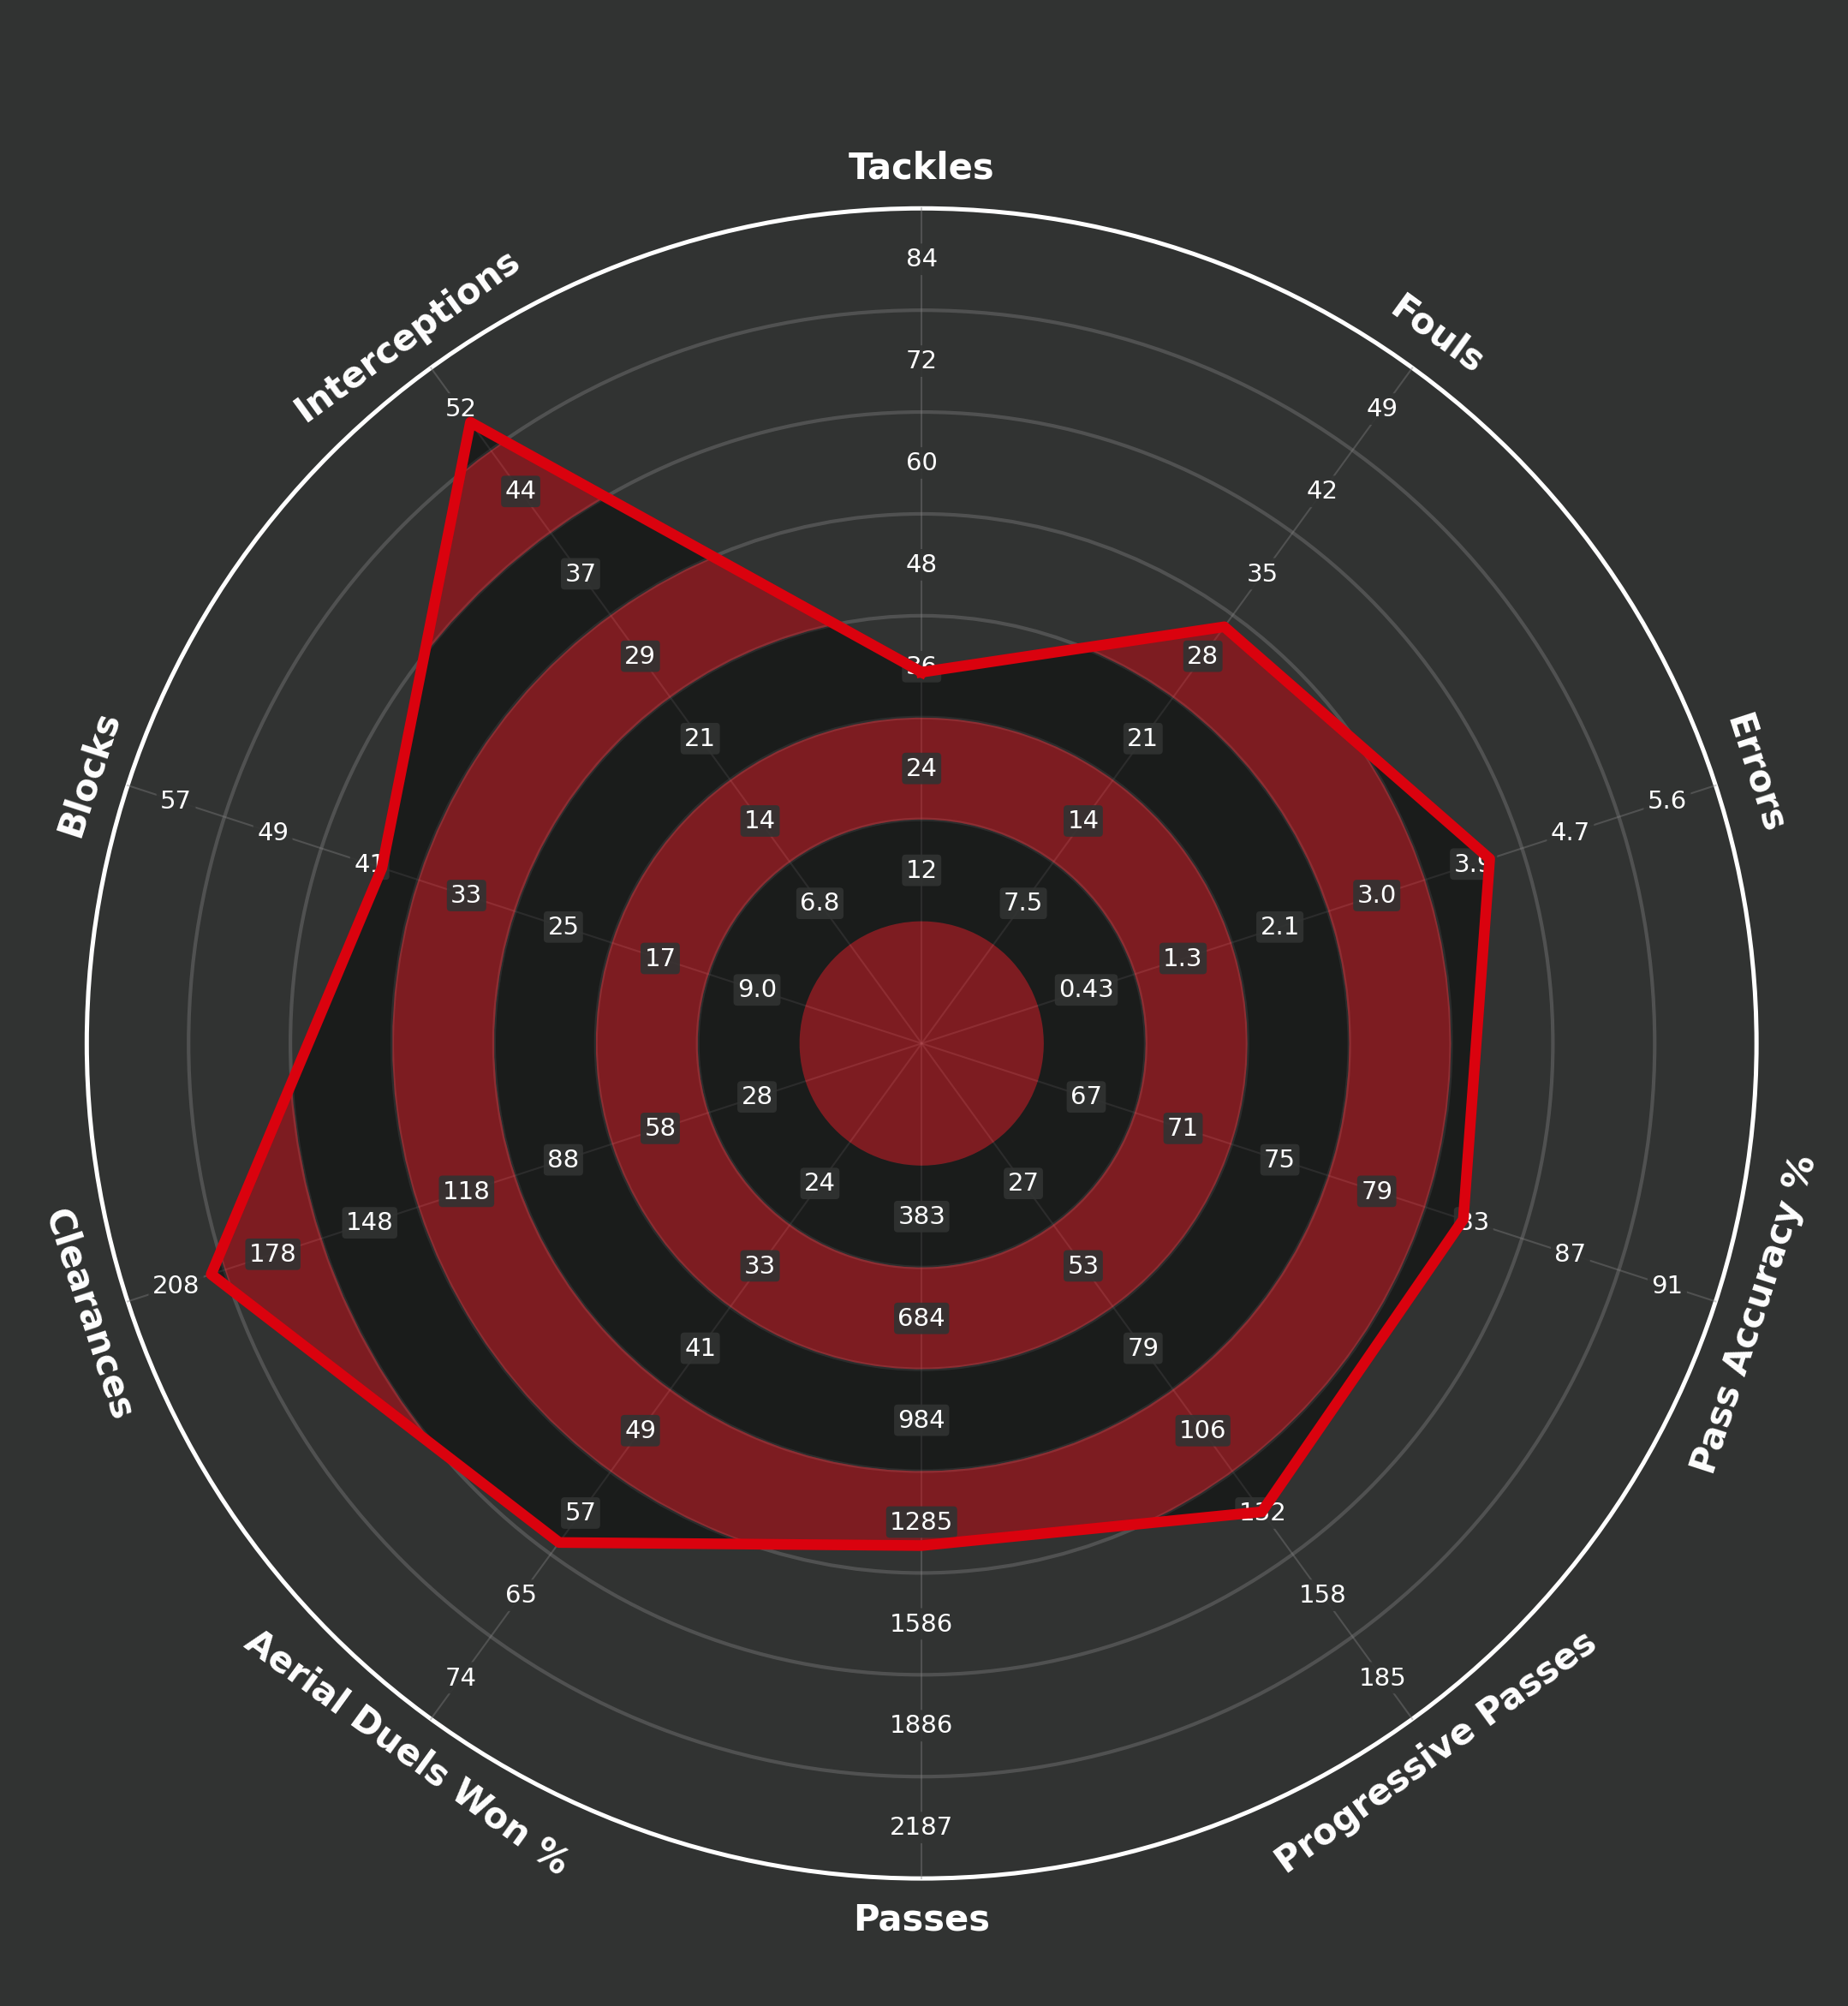


Generando radar Álex Baena (MF)...
Dataset: 555 jugadores MF
✓ Radar generado: ../images/radares_2425/Alex_Baena_MF.png


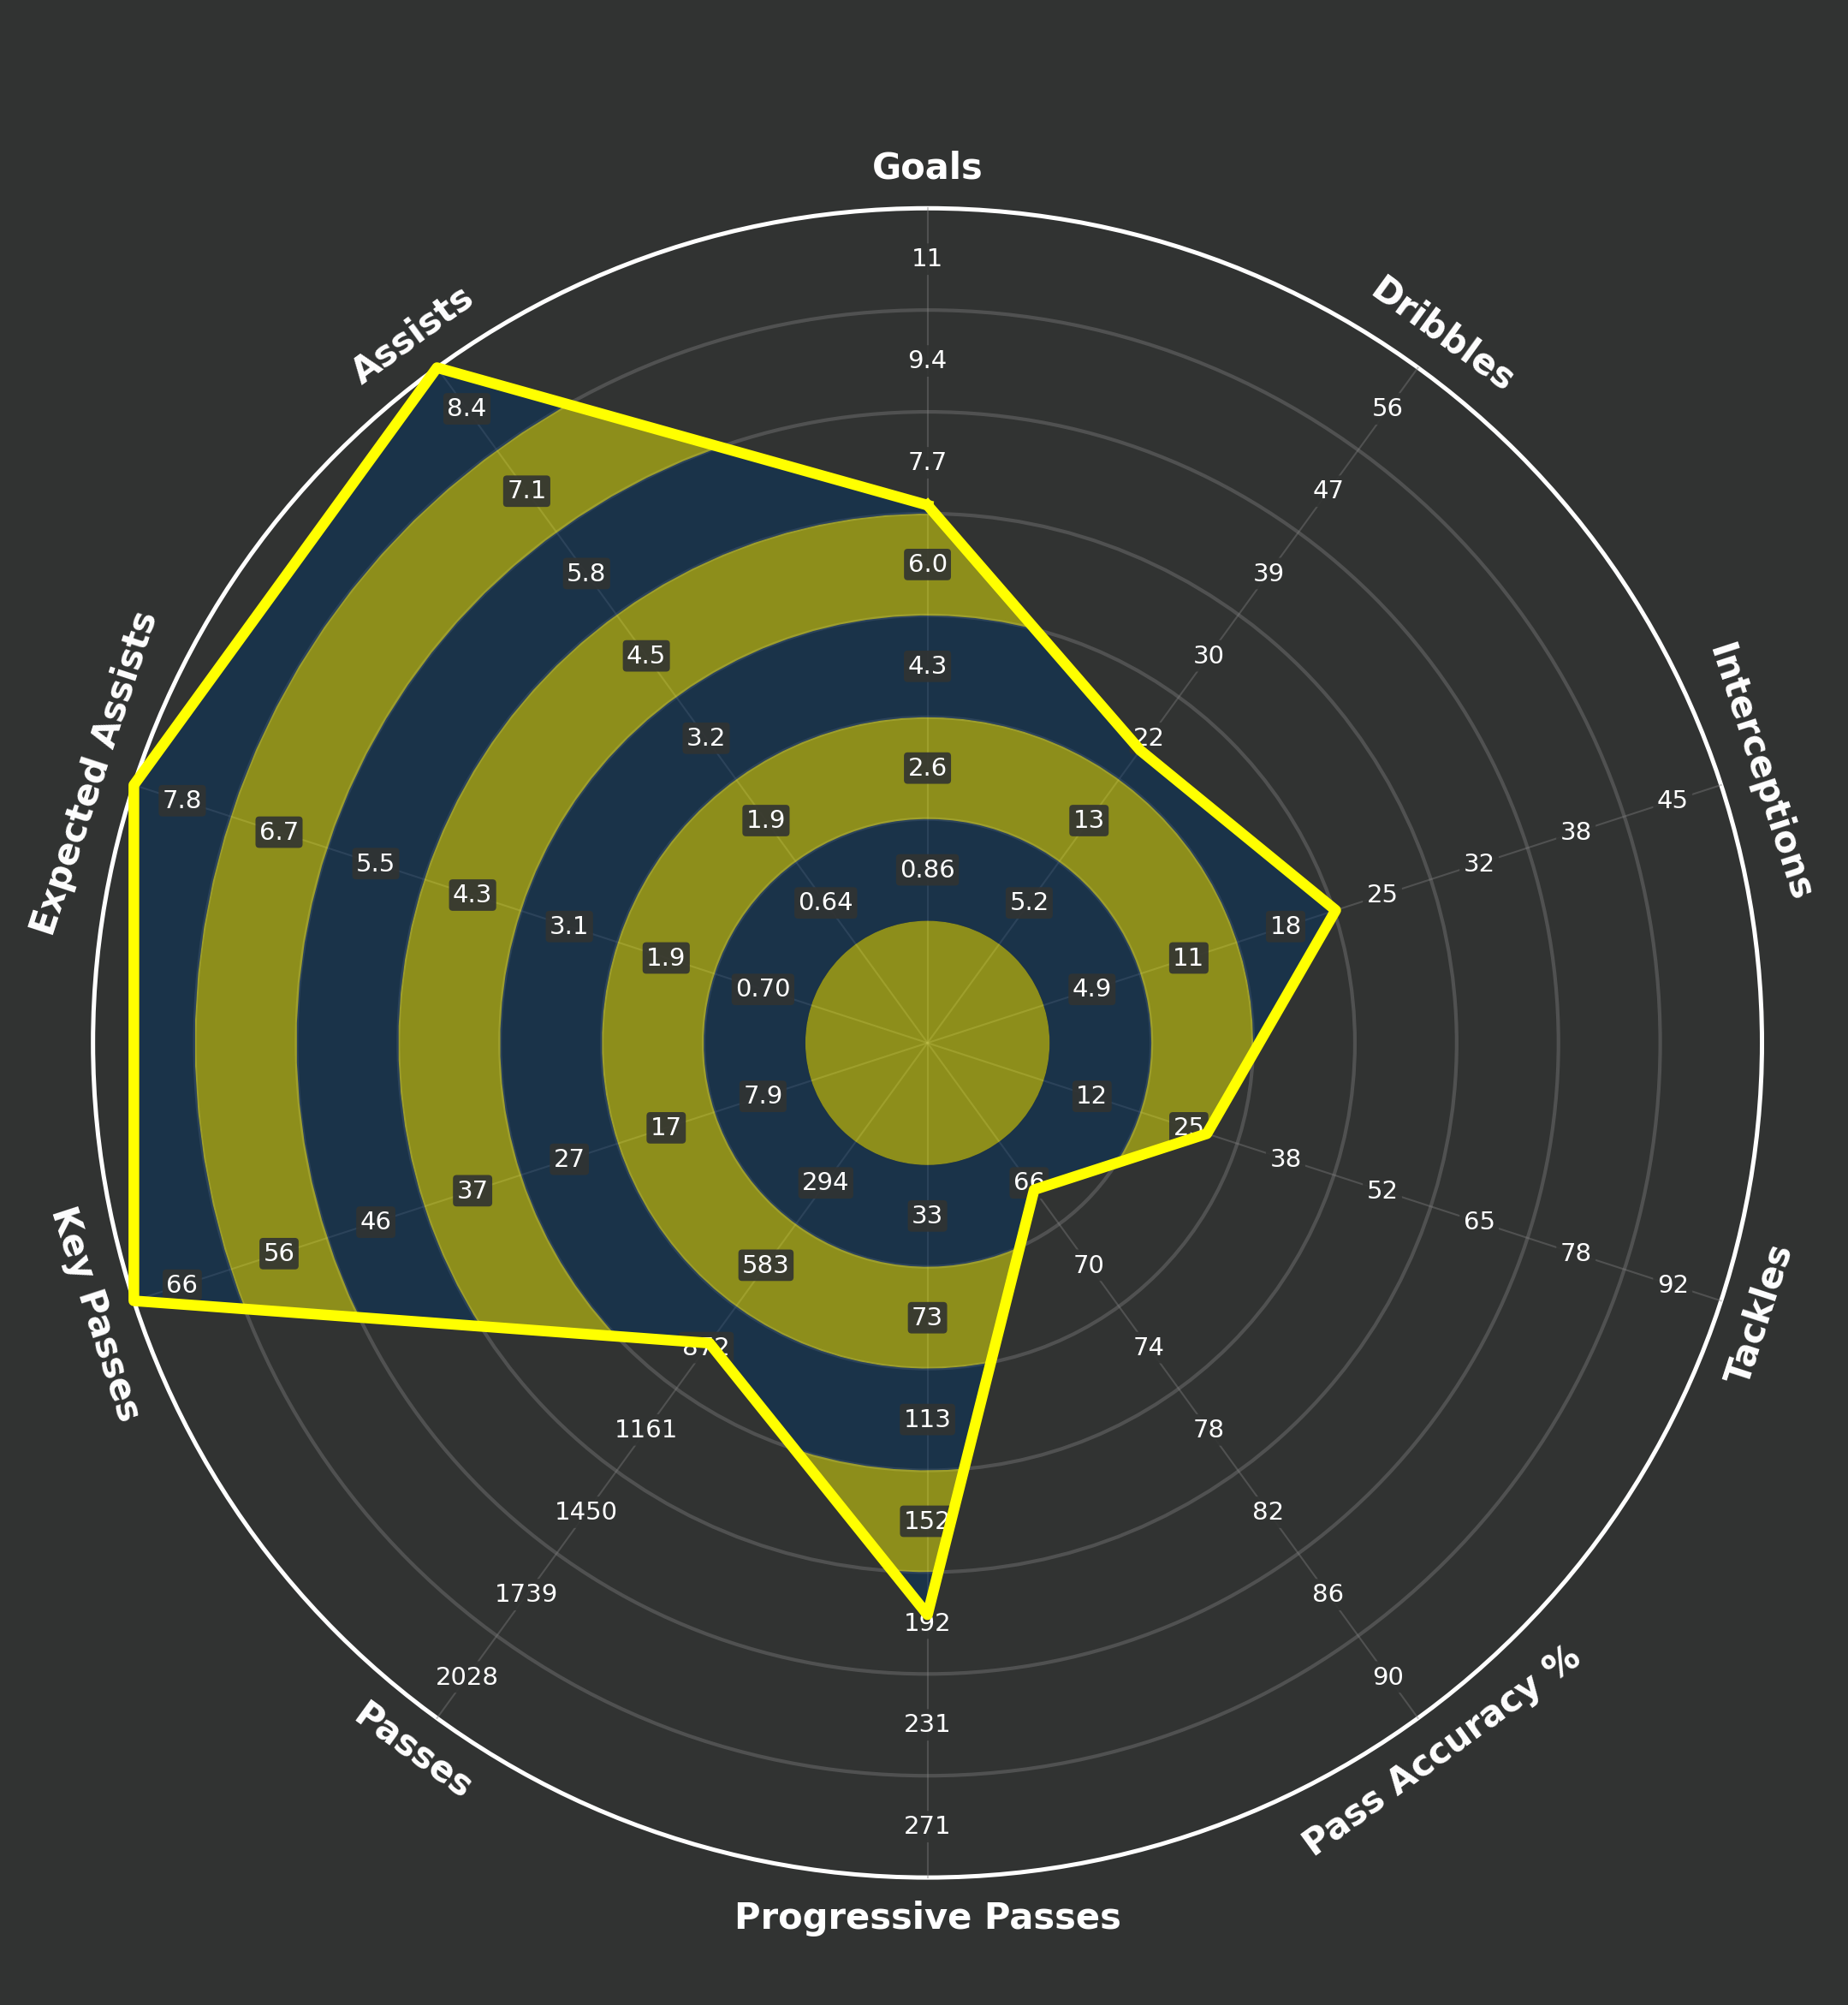


Generando radar Georges Mikautadze (FW)...
Dataset: 419 jugadores FW
✓ Radar generado: ../images/radares_2425/Georges_Mikautadze_FW.png


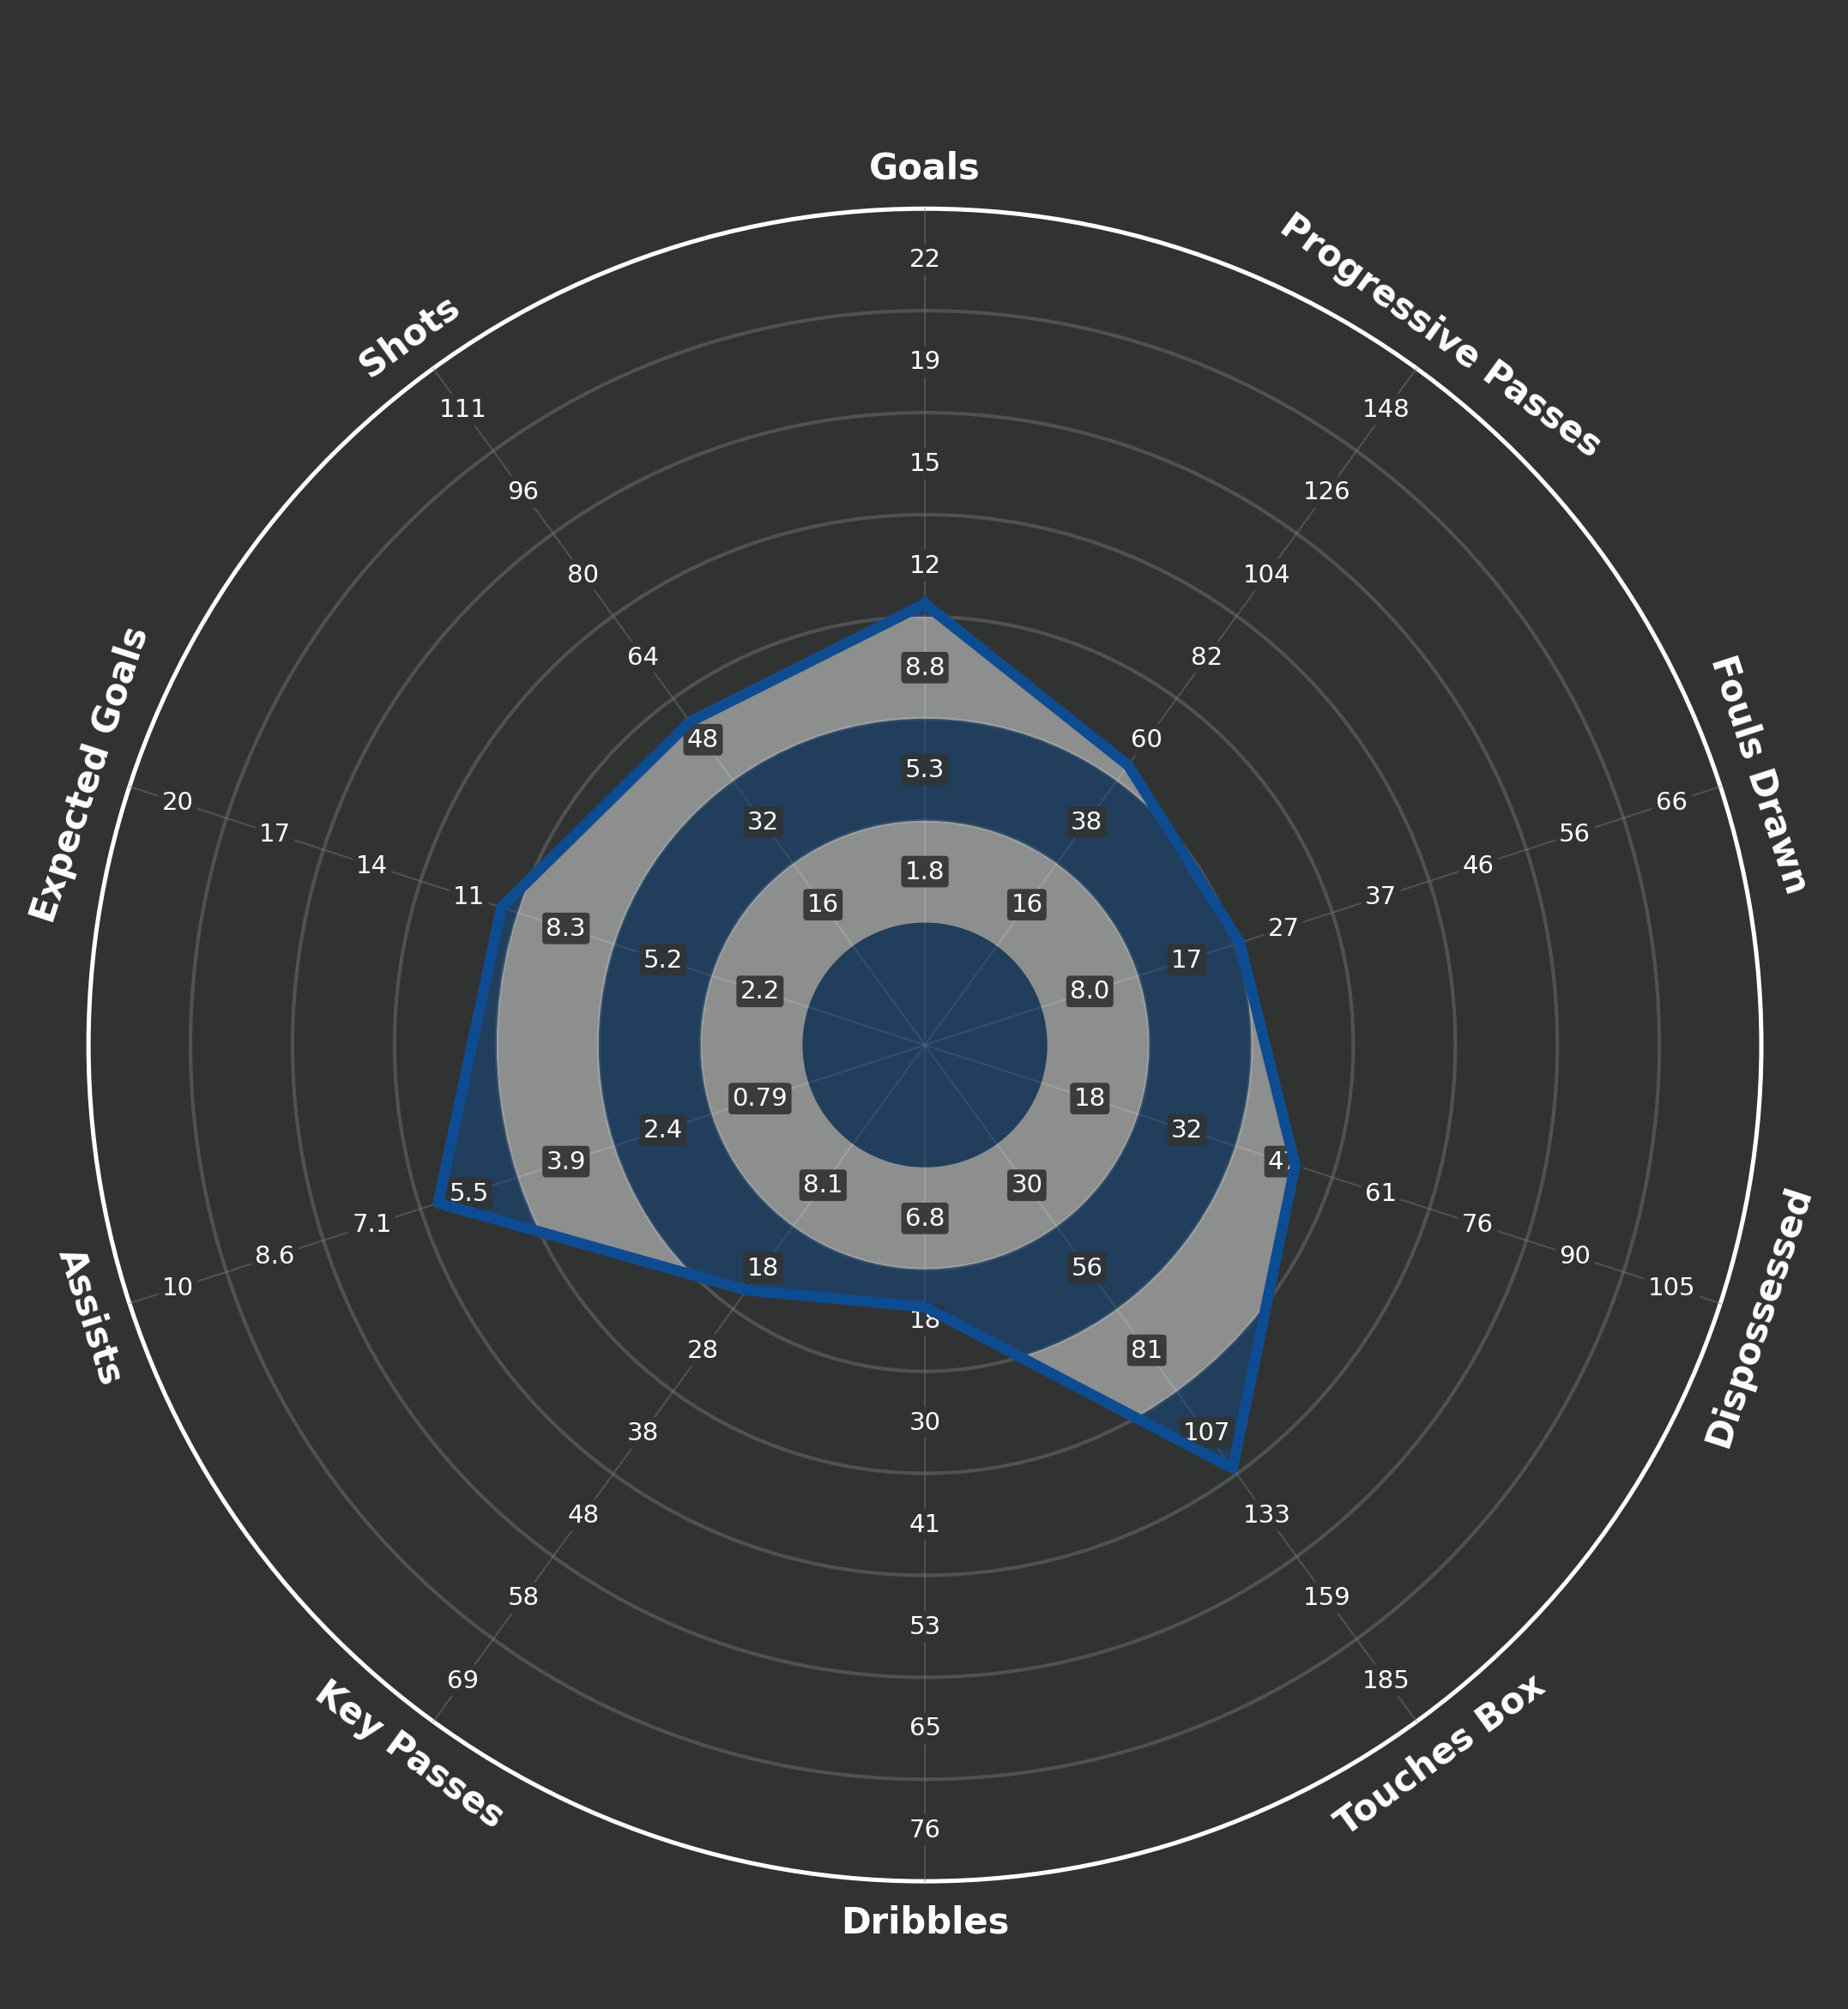

In [14]:
from viz.swarm_radar import create_player_radar
from IPython.display import Image as IPImage, display

# Configuración de radares
radar_configs = [
    {
        'player_id': PLAYER_1_ID,
        'player_name': 'Joan García',
        'position': 'GK',
        'metrics': gk_metrics,
        'titles': gk_titles,
        'colors': ['#004D98', '#FFFFFF'],
        'save_path': f"{SAVE_PATH_BASE}Joan_Garcia_GK.png"
    },
    {
        'player_id': PLAYER_2_ID,
        'player_name': 'Dean Huijsen',
        'position': 'DF',
        'metrics': df_metrics,
        'titles': df_titles,
        'colors': ['#DA020E', '#000000'],
        'save_path': f"{SAVE_PATH_BASE}Dean_Huijsen_DF.png"
    },
    {
        'player_id': PLAYER_3_ID,
        'player_name': 'Álex Baena',
        'position': 'MF',
        'metrics': mf_metrics,
        'titles': mf_titles,
        'colors': ['#FFFF00', '#003366'],
        'save_path': f"{SAVE_PATH_BASE}Alex_Baena_MF.png"
    },
    {
        'player_id': PLAYER_4_ID,
        'player_name': 'Georges Mikautadze',
        'position': 'FW',
        'metrics': fw_metrics,
        'titles': fw_titles,
        'colors': ['#0E4C92', '#FFFFFF'],
        'save_path': f"{SAVE_PATH_BASE}Georges_Mikautadze_FW.png"
    }
]

# Generar radares
for config in radar_configs:
    if config['player_id'] and len(config['metrics']) == 10:
        
        # Filtrar dataset por posición
        pos_filter = config['position']
        position_df = df_final[df_final['position'].str.startswith(pos_filter)].copy()
        
        print(f"\nGenerando radar {config['player_name']} ({config['position']})...")
        print(f"Dataset: {position_df.shape[0]} jugadores {config['position']}")
        
        try:
            create_player_radar(
                df_data=position_df,
                player_1_id=config['player_id'],
                metrics=config['metrics'],
                metric_titles=config['titles'],
                team_colors=config['colors'],
                save_path=config['save_path'],
                use_swarm=False,
                show_plot=False
            )
            
            print(f"✓ Radar generado: {config['save_path']}")
            display(IPImage(config['save_path']))
            
        except Exception as e:
            print(f"✗ Error: {str(e)}")
    else:
        print(f"\nSaltando {config['player_name']}: ID no configurado o métricas incompletas")